### 1) Train the classifier for apnea detection in rgbt data
### 2) Apply the classifier to epilepsy patients

In [13]:
from datetime import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px


from preepiseizures.src import Patient
import Respiration_2023 as resp

In [14]:
# choose patient
patient = 'BLIW'

# get metadata
patient_info = Patient.patient_class(patient)
patient_info.get_seizure_annotations()
patient_info.seizure_table

# get data
data_path = f'data{os.sep}respiration{os.sep}{patient}_all_respiration_data.parquet'

data = pd.read_parquet(data_path)
print(data.head(5))

data['datetime'] += pd.Timedelta(patient_info.patient_dict['temporal_shift'])


corr_points = pd.read_parquet(f'data{os.sep}respiration{os.sep}{patient}_respiration_corr_points_all.parquet')
time_corr_points = [pd.date_range(corr_points.index[i], corr_points.index[i]+pd.Timedelta(seconds=60), periods=10) for i in range(len(corr_points.index))]
corr_points = pd.DataFrame(np.hstack(corr_points.values), index=np.hstack(time_corr_points))
corr_points

data_part = data.loc[data['datetime'].between(corr_points.index[0], corr_points.index[-1])].copy()
print(data_part.head(5))
corr_points['datetime'] = corr_points.index
corr_points['datetime'] += pd.Timedelta(patient_info.patient_dict['temporal_shift'])


       RESP         ECG                      datetime
0 -0.550698  327.377781 2022-10-24 17:20:30.102147000
1 -1.115533  548.140230 2022-10-24 17:20:30.114649453
2 -0.980881  380.440441 2022-10-24 17:20:30.127151907
3 -1.068967  432.321766 2022-10-24 17:20:30.139654360
4 -1.015300  324.646437 2022-10-24 17:20:30.152156814
           RESP         ECG                      datetime
9256  -6.921530  308.794602 2022-10-24 18:10:50.754874000
9257 -13.749311  311.135258 2022-10-24 18:10:50.767374002
9258 -11.707818  308.327256 2022-10-24 18:10:50.779874005
9259 -12.477444  309.779907 2022-10-24 18:10:50.792374008
9260 -11.449182  310.320376 2022-10-24 18:10:50.804874011


In [17]:
corr_points.values.shape

(5423, 10)

 ...]

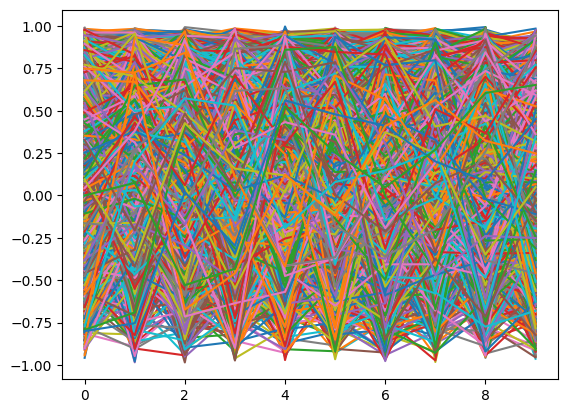

In [18]:
corr_points = pd.read_parquet(f'data{os.sep}respiration{os.sep}{patient}_respiration_corr_points_all.parquet')
plt.plot(corr_points.values.T)

In [ ]:

fictional_time = datetime.datetime(2021, 1, 1, 0, 0, 0)
data_seizures = pd.DataFrame()
corr_points_seizures = pd.DataFrame()
# get seizure times
for i in range(len(patient_info.seizure_table)):
    if patient_info.seizure_table.iloc[i]['Focal / Generalisada'] != 'FBTC':
        continue
    onset = patient_info.seizure_table['Timestamp'].iloc[i]
    start = onset - pd.Timedelta(minutes=30)
    end = onset + pd.Timedelta(minutes=30)
    seizure_i_data = data_part.loc[data_part['datetime'].between(start, end)].copy()
    seizure_i_data['seizure'] = i
    seizure_i_data['relative_time'] = seizure_i_data['datetime'] - onset
    seizure_i_data['onset'] = False
    seizure_i_data['onset'].iloc[np.argmin(np.abs(seizure_i_data['relative_time']))] = True
    corr_points_seizure_i = corr_points.loc[corr_points['datetime'].between(start, end)].copy()
    corr_points_seizure_i['seizure'] = i
    corr_points_seizure_i['relative_time'] = corr_points_seizure_i['datetime'] - onset
    corr_points_seizure_i['onset'] = False
    corr_points_seizure_i['onset'].iloc[np.argmin(np.abs(corr_points_seizure_i['relative_time']))] = True

    seizure_i_data['fictional_time'] = fictional_time + seizure_i_data['relative_time']
    corr_points_seizure_i['fictional_time'] = fictional_time + corr_points_seizure_i['relative_time']
    seizure_i_data['index'] = np.arange(len(seizure_i_data))
    resp_rate, resp_times = biosignal_processing.resp_rate(seizure_i_data['RESP'], 80)
    seizure_i_data['resp_rate'] = np.nan
    seizure_i_data['resp_rate'].iloc[np.array(resp_times)-1] = resp_rate
    data_seizures = pd.concat((data_seizures, seizure_i_data), ignore_index=True)
    corr_points_seizure_i['corr'] = corr_points_seizure_i[0].astype(float)
    corr_points_seizure_i['index'] = np.arange(len(corr_points_seizure_i))
    #corr_points_seizure_i['label'] = np.hstack(['preictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].
    #                                                                              between(start, onset)]) + ['ictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].between(onset, onset + pd.Timedelta(minutes=2))]) + ['postictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].between(onset + pd.Timedelta(minutes=2), end)]))
    corr_points_seizures = pd.concat((corr_points_seizures, corr_points_seizure_i), ignore_index=True)

data_seizures.loc[data_seizures['onset'] == True]

In [ ]:


fig = sns.lmplot( data=data_seizures, hue='onset', palette=['#83A19B'], y='resp_rate', x='index', col='seizure', order=4, fit_reg=True, col_wrap=3, sharex=False, sharey=False)
i = 1

for axis in fig.axes:
    seizure_i_data = data_seizures.loc[data_seizures['seizure']==i].copy()
    axis.set_xlabel('Time (s)')
    axis.set_ylabel('Respiration rate (breaths/min)')
    axis.set_ylim(0, 35)#seizure_i_data['resp_rate'].max()+1)
    axis.lines[0].set_color('#03587B')
    axis.set_xticks(seizure_i_data['index'][::len(seizure_i_data)//8])
    axis.set_xticklabels(seizure_i_data['datetime'][::len(seizure_i_data)//8].dt.strftime('%H:%M:%S'), rotation=45)
    axis.vlines(seizure_i_data.loc[seizure_i_data['onset']==True, 'index'], 0, 50, color='#951428')
    i += 1

plt.savefig(f'data/figures{os.sep}{patient}_respiration_rate_seizures.pdf')